In [1]:
import numpy as np
import matplotlib.pyplot as plt #debug
from scipy import interpolate


In [2]:
def triangle_weight(Nx, begin=None, end=None, peak=None):
    if(begin == None):
        begin = 0
    if(end   == None):
        end   = Nx
    if(peak  == None):
        peak  = int((end+begin)/2)
    if(peak < begin or peak > end):
        raise ValueError("Peak outside triangle bounds")
    if(begin >= end):
        raise ValueError("Incorrect bounds order: begin >= end")
    triangle = np.hstack((np.zeros(begin),
                          np.linspace(0,1,peak-begin, endpoint=False),
                          np.linspace(1,0,end-peak),
                          np.zeros(Nx-end)))
    return triangle


In [3]:
def asym_triangle(Nx, begin=None, end=None, peak=None):
    if(begin == None):
        begin = 0
    if(end   == None):
        end   = Nx
    if(peak  == None):
        peak  = int((end+begin)/2)
    triangle = triangle_weight(Nx, begin=begin, end=end, peak=peak-1)
    triangle[peak:] = np.hstack((0,-triangle[peak:-1]))
    return triangle

In [4]:
N_file = 321
model1_X = np.reshape(np.fromfile("model_2-X.txt", sep=' '), (N_file,N_file)) #read data from file and convert it to 2d array
model1_Y = np.reshape(np.fromfile("model_2-Y.txt", sep=' '), (N_file,N_file))
model1_Z = np.reshape(np.fromfile("model_2-Z.txt", sep=' '), (N_file,N_file))

print(np.amin(model1_Z))
print(model1_Z.mean())
print(np.amax(model1_Z))


448.7007
683.9578777522539
1128.0434


In [7]:
# mesh size
#(Nx,Ny,Nz) = (161,161,61)
(Nx,Ny,Nz) = (51,51,51)
#mesh SIZE
Lxy = 8000
Lz_rock  = 2000
Lz = Lz_rock+model1_Z.mean()

#boundaries of the curved region
z_start = 0
z_stop  = Nz

#ocean floor
k_border = round(Nz * model1_Z.mean() / Lz )

In [8]:
#generate an empty array for vertices
vertices = np.zeros((Nx,Ny,Nz,3))

#generate xy values
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
z = np.linspace(0,1,Nz)

x = x * Lxy - Lxy / 2
y = y * Lxy - Lxy / 2
z = z * Lz

#populate with rect mesh
for k in range(0,Nz):
    for j in range(0,Ny):
        for i in range(0,Nx):
            vertices[i,j,k,:] = (x[i], y[j], z[k])


In [9]:
ot_file = "Saltf@@"
(ot_Nx,ot_Ny,ot_Nz)=(676,676,210)

ot_x = np.linspace(-Lxy/2,Lxy/2,ot_Nx)
ot_y = np.linspace(-Lxy/2,Lxy/2,ot_Ny)
ot_z = np.linspace(0,Lz_rock,ot_Nz)

ot_c=np.reshape(np.fromfile(ot_file,dtype='>f4'),(ot_Nz,ot_Ny,ot_Nx))
f_ot_c=interpolate.RegularGridInterpolator((ot_z,ot_y,ot_x),ot_c)
interp_ot_c = np.empty((Nz-k_border,Ny,Nx))
for k in range(0,Nz-k_border):
    print(k)
    for j in range(0,Ny):
        for i in range(0,Nx):
            interp_ot_c[k,j,i] = f_ot_c((z[k], y[j], x[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [10]:
#plt.figure(figsize=(16,8))
#plt.imshow(ot_c[:,-1,:])

In [11]:
#plt.figure(figsize=(16,8))
#plt.imshow(interp_ot_c[:,-1,:])

In [12]:
f_dz = interpolate.interp2d(model1_X[0,1:-3], model1_Y[1:-3,0], model1_Z[1:-3,1:-3])

#calculate offsets
#xygrid = np.transpose(np.array(np.meshgrid(x,y)), (2,1,0)) #iirc this makes a 2d array of (x,y) pairs
#dz = f(xygrid[:,:,0], xygrid[:,:,1], 0.7)/2 #feed that array into the bulge function
interp_dz = f_dz(x, y)  #interpolate heightmap to target mesh size
dz_mean = np.mean(interp_dz)
#k_border = np.array(np.where(z < dz_mean)).flatten()[-1] #closest* mesh z-plane to dz_mean
#print(k_border)
interp_dz -= z[k_border]
weights = triangle_weight(Nz, z_start, z_stop, k_border)
#weights_condense = asym_triangle(Nz, z_start, z_stop, k_border)
weights_condense = 1-weights
#weights_condense[[0,-1]] = 0
weights_condense[k_border:] = -weights_condense[k_border:]
weights_condense = (np.abs(weights_condense)**4)*np.sign(weights_condense)

#print(weights)

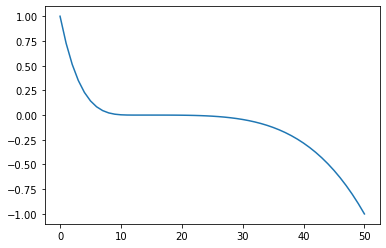

In [13]:
plt.plot(weights_condense)

In [14]:
#plt.imshow(model1_Z)

214.7166302201803


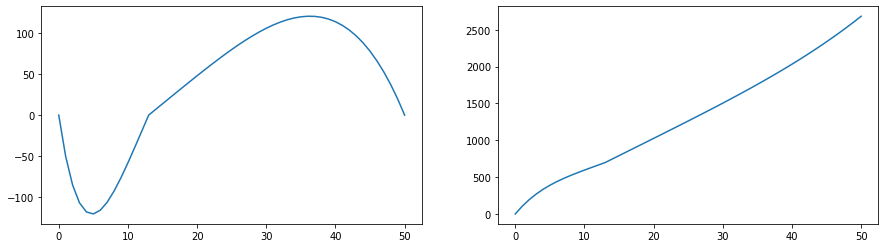

In [15]:
delta_z=(Lz/(Nz-1))*4
print(delta_z)
condense_dz = delta_z*weights_condense - delta_z
unshrink_coef = Lz/(Lz-2*delta_z)
condense_dz = (z+condense_dz)*unshrink_coef-z
condense_dz -= weights*condense_dz[k_border]
ax = plt.figure(figsize=(15,4)).subplots(1,2)
ax[0].plot(condense_dz)
ax[1].plot((z-condense_dz))

In [16]:
#apply offsets
for k in range(0,Nz):
    vertices[:,:,k,2] += (interp_dz*weights[k] - condense_dz[k])
#todo: make condense offset and curve offset aware of each other or act one after another or something. 
#Right now they can sometimes clip through each other and result in negative cell height.

In [17]:
cell_heights = vertices[:,:,1:,2]-vertices[:,:,:-1,2]

In [18]:
np.amin(cell_heights)

14.976833179364064

In [23]:

N_NODES = Nx*Ny*Nz
N_CELLS = (Nx-1)*(Ny-1)*(Nz-1)

with open('salt_index.vtk', 'w') as f:
    # write header
    f.write('# vtk DataFile Version 3.0\n')
    f.write('Generated by mfem-seismo\n')
    f.write('ASCII\n')
    f.write('DATASET UNSTRUCTURED_GRID\n')
    
    # write point coordinates
    f.write(' '.join(['POINTS', str(N_NODES), 'double\n']))
    #for k in range(Nz-1, -1, -1):
    for k in range(0, Nz):
        for j in range(0, Ny):
            for i in range(0, Nx):
                f.write(' '.join([str(vertices[i][j][k][0]), str(vertices[i][j][k][1]), str(vertices[i][j][k][2]), '\n']))
                
    #fill cell vertices
    f.write(' '.join(['CELLS', str(N_CELLS), str(9 * N_CELLS), '\n']))
    Nx -= 1
    Ny -= 1
    Nz -= 1
    for i in range(Nz):
        for j in range(Ny):
            for k in range(Nx):
                f.write(' '.join(['8', str((Nx+1)*(Ny+1)*i+j*(Nx+1)+k), str((Nx+1)*(Ny+1)*i+j*(Nx+1)+k+1), # 8 means num_of_nodes_per_cell
                    str((Nx+1)*(Ny+1)*i+(j+1)*(Nx+1)+k+1), str(((Nx+1)*(Ny+1)*i+(j+1)*(Nx+1)+k)),
                    str((Nx+1)*(Ny+1)*(i+1)+j*(Nx+1)+k), str((Nx+1)*(Ny+1)*(i+1)+j*(Nx+1)+k+1),
                    str((Nx+1)*(Ny+1)*(i+1)+(j+1)*(Nx+1)+k+1), str(((Nx+1)*(Ny+1)*(i+1)+(j+1)*(Nx+1)+k)),
                    '\n'])) #
    
    #fill cell types for somr reason
    f.write(' '.join(['CELL_TYPES', str(N_CELLS), '\n']))
    for _ in range(N_CELLS):
        f.write('12\n') # magic constant for VTK_QUAD
    
    f.write(' '.join(['CELL_DATA', str(N_CELLS), '\n']))
    f.write('SCALARS index int\n')
    f.write('LOOKUP_TABLE default\n')
    
    
    #for _ in range(0, k_border * (Nx * Ny)):
    #    f.write('1\n')
    #for _ in range(k_border * (Nx * Ny), N_CELLS):
    #    f.write('2\n')
    for k in range(0, Nz):
        print(k)
        for j in range(0, Ny):
            for i in range(0, Nx):
                #f.write(''.join([str(interp_ot_c[k-k_border,j,i]) if k >= k_border else '1500','\n']))
                f.write(''.join([str(k*Ny*Nx+j*Nx+i+1),'\n']))
    
    Nx += 1
    Ny += 1
    Nz += 1 #so that i don't have to restart kernel every time i rerun this block





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [28]:
with open('salt_values.txt', 'w') as f:
    Nx -= 1
    Ny -= 1
    Nz -= 1
    for k in range(0, Nz):
        print(k)
        for j in range(0, Ny):
            for i in range(0, Nx):
                f.write(''.join([str(interp_ot_c[k-k_border,j,i]) if k >= k_border else '1500','\n']))
                #f.write(''.join([str(k*Ny*Nx+j*Nx+i+1),'\n']))
    Nx += 1
    Ny += 1
    Nz += 1 #so that i don't have to restart kernel every time i rerun this block

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
